# Kurtosis and similar methods for identifying outliers in prescribing

This notebook looks at each chemical prescribed in England (using national prescribing data), assigns it to its class (BNF subparagraph) and, for each Clinical Commissioning Group, calculates the chemical-class proportion. 

Chemicals are then ranked by (a) their kurtosis and (b) a ratio between inter-centile differences, in order to identify those with extreme distributions, i.e. outliers. 

In [1]:

import pandas as pd
import numpy as np
from ebmdatalab import bq
import os

q = '''SELECT p.* FROM ebmdatalab.outlier_detection.chem_by_subpara_by_ccg_juntoaug17_limitsubpara p
-- exclude non-standard CCG codes:
INNER JOIN ebmdatalab.hscic.ccgs c ON p.pct = c.code AND c.org_type = "CCG"
'''
# see chemical_by_subpara.sql for data source production

df1 = bq.cached_read(q, csv_path=os.path.join("..","data","df1.csv"), use_cache=True)
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = bq.cached_read(q2, csv_path=os.path.join("..","data","chemical.csv"), use_cache=True)

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = bq.cached_read(q3, csv_path=os.path.join("..","data","subpara.csv"), use_cache=True)

df1.head()

,pct,chemical,subpara,num,denom,ratio
0,00C,0101010C0,101010,4,217,0.018433
1,00C,0101010G0,101010,198,217,0.912442
2,00C,0101010L0,101010,1,217,0.004608
3,00C,0101010R0,101010,14,217,0.064516
4,00D,0101010G0,101010,553,637,0.868132


## Clean the data: sort out null denominators

In [2]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph,, even if not prescribed.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all ccgs
b = df1[["pct"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - this will list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","subpara","denom"]].groupby(["subpara","pct"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)
data2.head()


,pct,subpara,denom_subpara,chemical,num,denom,ratio
0,00C,101010,217.0,0101010C0,4.0,217.0,0.018433
1,00C,101010,217.0,0101010G0,198.0,217.0,0.912442
2,00C,101010,217.0,0101010L0,1.0,217.0,0.004608
3,00C,101010,217.0,0101010R0,14.0,217.0,0.064516
4,00C,101010,217.0,0101010J0,0.0,0.0,0.000000


### Filter out low numbers (chemical and subpara)

In [3]:
# total prescribing for each chemical
# sum numerators to find total volume for each chemical across all ccgs
num = pd.DataFrame(df1["num"].groupby(df1["chemical"]).sum()).reset_index()

# calculate centile for numerator for each ccg
num["num centile"] = pd.qcut(num["num"], 10, labels=np.arange(1,11,1))

# total prescribing for each paragraph
d3 = d2[["pct","subpara","denom_subpara"]].drop_duplicates()
d3 = d3.groupby("subpara").sum().sort_values(by="denom_subpara")
d3["denom centile"] = pd.qcut(d3["denom_subpara"], 10, labels=np.arange(1,11,1))
d3 = d3.reset_index()


# merge with data table
data3 = data2.merge(num, how="inner", on="chemical",suffixes=("","_total"))
data3 = data3.merge(d3, how="inner", on="subpara",suffixes=("","_total"))

num_chemicals_stage0 = data3['chemical'].nunique()

# filter out CCGs with lowest denominator values
data3 = data3.loc[(data3["denom centile"]>2)]

num_chemicals_stage1 = data3['chemical'].nunique()
num_chemicals_lost_01 = num_chemicals_stage0 - num_chemicals_stage1

# num of CCGs prescribing each chemical
count_ = pd.DataFrame(data3.loc[data3["num"]>0].groupby("chemical")["pct"].nunique()).reset_index()
count_ = count_.rename(columns={"pct":"count2"})

data3 = data3.merge(count_, how="inner", on="chemical")

data3.head()

,pct,subpara,denom_subpara,chemical,num,denom,ratio,num_total,num centile,denom_subpara_total,denom centile,count2
0,00C,101010,217.0,0101010C0,4.0,217.0,0.018433,1423,5,39497.0,4,125
1,00D,101010,637.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125
2,00J,101010,520.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125
3,00K,101010,321.0,0101010C0,16.0,321.0,0.049844,1423,5,39497.0,4,125
4,00L,101010,322.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125


## Calculate key stats
### Median, Range, SD, Kurtosis and Skew

In [4]:
#select columns of interest and get key stats
df2 = pd.DataFrame(data3.groupby(["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count2"])["ratio"].describe())
#df2 = df2.unstack()
#df2.columns = df2.columns.droplevel()

df3 = df2.reset_index()
df3["range"] = df3["max"] - df3["min"]
df3 = df3[["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count","count2","50%","min","max","range","std"]].rename(columns={"50%":"median"})

num_chemicals_stage2 = df3['chemical'].nunique()

# filter out chemicals in paragraphs only prescribed by few CCGs
df3 = df3.loc[df3["count"]>=50]

num_chemicals_stage3 = df3['chemical'].nunique()
num_chemicals_lost_23 = num_chemicals_stage2 - num_chemicals_stage3


# reshape data to put CCGs in columns
df5 = data3.pivot(index="chemical",columns='pct', values='ratio')

#calculate kurtosis and skew for each chemical
import scipy.stats as stats
k = pd.Series(stats.kurtosis(df5, axis=1,nan_policy="omit"),name="kurtosis")
sk =  pd.Series(stats.skew(df5, axis=1,nan_policy="omit"),name="skew")

# compile all stats together
result = pd.concat([df3, k, sk], axis=1).sort_values(by="kurtosis",ascending=False)
result = result[["chemical","subpara", "count","count2","num_total","num centile","median","min","max","range","std","kurtosis","skew"]].round(2)


# Lookup chemical and subparagraph names
df4 = result.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
df4 = df4.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
df4 = df4[["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","count2","median","min","max","range", "std","kurtosis","skew"]].round(2)
df4["subpara"] = df4["subpara"].fillna(0).astype(int).astype(str)

df4.head()

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew
0,0501012G0,Flucloxacillin sodium,501012,Penicillinase-resistant penicillins,1058061.0,10,207.0,207.0,1.0,1.0,1.0,0.0,0.0,202.0,-14.28
1,0304010F0,Brompheniramine maleate,304010,Antihistamines,8.0,1,207.0,1.0,0.0,0.0,0.0,0.0,0.0,202.0,14.28
2,0401020A0,Alprazolam,401020,Anxiolytics,1.0,1,207.0,1.0,0.0,0.0,0.0,0.0,0.0,202.0,14.28
3,020400010,Pindolol with diuretic,204000,Beta-adrenoceptor blocking drugs,1.0,1,207.0,1.0,0.0,0.0,0.0,0.0,0.0,202.0,14.28
4,0208020S0,Phenprocoumon,208020,Oral anticoagulants,1.0,1,207.0,1.0,0.0,0.0,0.0,0.0,0.0,202.0,14.28


In [5]:
### df5 is a chemical X CCG - raw data

print( df5.head )
print( df5.columns )
print( df5.shape )


<bound method NDFrame.head of pct             00C       00D       00J       00K       00L       00M  \
chemical                                                                
0101010C0  0.018433  0.000000  0.000000  0.049844  0.000000  0.000000   
0101010F0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0101010G0  0.912442  0.868132  0.857692  0.707165  0.795031  0.620690   
0101010I0  0.000000  0.000000  0.000000  0.015576  0.003106  0.025862   
0101010J0  0.000000  0.015699  0.021154  0.024922  0.015528  0.008621   
...             ...       ...       ...       ...       ...       ...   
1502010J0  0.949744  0.951163  0.928339  0.973367  0.970890  0.946181   
1502010P0  0.000000  0.000000  0.009229  0.000000  0.000000  0.000000   
1502010S0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1502010V0  0.000000  0.000000  0.000543  0.000000  0.000410  0.000000   
1502010Y0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

pct             00N 

In [6]:
### df4 contains df5 data, processed and summarised, including kurtosis and skew

print( df4.head )
print( df4.columns )
print( df4.shape )


<bound method NDFrame.head of        chemical                  chemical name  subpara  \
0     0501012G0          Flucloxacillin sodium   501012   
1     0304010F0        Brompheniramine maleate   304010   
2     0401020A0                     Alprazolam   401020   
3     020400010         Pindolol with diuretic   204000   
4     0208020S0                  Phenprocoumon   208020   
...         ...                            ...      ...   
1390  0501015P0    Pivmecillinam hydrochloride   501015   
1391  0505010D0                    Mebendazole   505010   
1392  0201010F0                        Digoxin   201010   
1393  130802000  Other camouflage preparations  1308020   
1394  090402000              Enteral nutrition   904020   

                             subpara name  num_total num centile  count  \
0     Penicillinase-resistant penicillins  1058061.0          10  207.0   
1                          Antihistamines        8.0           1  207.0   
2                             Anxiol

## Ranking Chemicals by Range, Kurtosis, Skew and SD
Those with high SD tend to be chemicals where there is general disagreement, so outliers are not *that* unusual

In [7]:
# limit to those with positive skew, i.e. most CCGs prescribe few and those prescribing more are ouliers,
# and range at least 10%:

num_chemicals_stage4 = df4['chemical'].nunique()

dfp = df4.loc[(df4["skew"]>=0) & (df4["range"]>0.1)]

num_chemicals_stage5 = dfp['chemical'].nunique()
num_chemicals_lost_45 = num_chemicals_stage4 - num_chemicals_stage5


# sort by range
r1 = dfp.sort_values(by=["range","kurtosis"],ascending=False)
# create a ranking
r1["R"]  = r1["range"].rank(ascending=False, method="min")

# sort by kurtosis 
r2 = dfp.sort_values(by=["kurtosis"],ascending=False)
r2["K"] = r2["kurtosis"].rank(ascending=False, method="min")

# sort by skew
r3 = dfp.sort_values(by=["skew"],ascending=False)
r3["Sk"] = r3["skew"].rank(ascending=False, method="min")

r1 = dfp.copy()
# create a ranking
r1["R"] = r1["range"].rank(ascending=False, method="min")
r1["K"] = r1["kurtosis"].rank(ascending=False, method="min")
r1["Sk"] = r1["skew"].rank(ascending=False, method="min")


r1.sort_values(by="K").head(20)

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk
70,1310011AA,Retapamulin,1310011,Antibacterial preparations only used topically,622.0,4,189.0,25.0,0.00,0.0,0.68,0.68,0.05,157.67,12.36,50.0,1.0,1.0
94,090602700,Other vitamin B compound preparations,906027,Vitamin B compound,1070.0,4,207.0,116.0,0.00,0.0,0.17,0.17,0.01,126.43,10.67,307.0,2.0,2.0
114,0601021X0,Tolbutamide,601021,Sulfonylureas,7666.0,6,207.0,187.0,0.00,0.0,0.12,0.12,0.01,110.49,9.49,375.0,3.0,3.0
155,0206040AF,Nicotinic acid derivatives,206040,Peripheral vasodilators and related drugs,70.0,3,185.0,24.0,0.00,0.0,0.13,0.13,0.01,88.27,8.85,354.0,4.0,4.0
177,0902011L0,Calcium polystyrene sulfonate,902011,Oral potassium,561.0,4,192.0,118.0,0.01,0.0,0.43,0.43,0.04,74.50,7.47,132.0,5.0,7.0
180,0501021B0,Cefadroxil,501021,Cephalosporins,1107.0,4,207.0,96.0,0.00,0.0,0.25,0.25,0.02,71.29,7.41,236.0,6.0,8.0
192,0101010F0,Magnesium carbonate,101010,Antacids and simeticone,119.0,3,192.0,25.0,0.00,0.0,0.19,0.19,0.02,66.74,7.53,293.0,7.0,6.0
196,0504010L0,Mefloquine hydrochloride,504010,Antimalarials,4625.0,5,207.0,89.0,0.00,0.0,0.32,0.32,0.04,64.92,8.15,191.0,8.0,5.0
205,0501120X0,Levofloxacin,501120,Quinolones,4637.0,6,207.0,201.0,0.02,0.0,0.37,0.37,0.03,61.48,6.32,161.0,9.0,13.0
222,0905013N0,Magnesium sulfate,905013,Magnesium,108.0,3,156.0,33.0,0.00,0.0,0.21,0.21,0.02,55.03,6.61,278.0,10.0,12.0


In [8]:
### dfp filters df4 for only those chemicals showing a positive skew and a range of >10%

print( dfp.head )
print( dfp.columns )
print( dfp.shape )


<bound method NDFrame.head of        chemical                          chemical name  subpara  \
70    1310011AA                            Retapamulin  1310011   
94    090602700  Other vitamin B compound preparations   906027   
114   0601021X0                            Tolbutamide   601021   
155   0206040AF             Nicotinic acid derivatives   206040   
177   0902011L0          Calcium polystyrene sulfonate   902011   
...         ...                                    ...      ...   
1373  0803042N0                    Leuprorelin acetate   803042   
1375  0803041L0                              Letrozole   803041   
1376  0803041B0                            Anastrozole   803041   
1377  0208010L0                      Dalteparin sodium   208010   
1378  0208010D0                             Enoxaparin   208010   

                                        subpara name  num_total num centile  \
70    Antibacterial preparations only used topically      622.0           4   
94     

### Add hyperlinks to maps

In [9]:
# assign overall scores based on all three rankings

r2 = r1.copy()
columns = ["R","K","Sk"]
r2['score'] = 0
for col in columns:
    r2.loc[r2[col]<=10, 'score'] = r2['score']+10 # if in top 10, score 10
    r2.loc[(r2[col]>10)&(r2[col]<=50), 'score'] = r2['score']+5 # if in top 10, score 10
rc = r2.sort_values(by=["score","kurtosis"],ascending=False)
rc.head()

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk,score
70,1310011AA,Retapamulin,1310011,Antibacterial preparations only used topically,622.0,4,189.0,25.0,0.00,0.0,0.68,0.68,0.05,157.67,12.36,50.0,1.0,1.0,25
94,090602700,Other vitamin B compound preparations,906027,Vitamin B compound,1070.0,4,207.0,116.0,0.00,0.0,0.17,0.17,0.01,126.43,10.67,307.0,2.0,2.0,20
114,0601021X0,Tolbutamide,601021,Sulfonylureas,7666.0,6,207.0,187.0,0.00,0.0,0.12,0.12,0.01,110.49,9.49,375.0,3.0,3.0,20
155,0206040AF,Nicotinic acid derivatives,206040,Peripheral vasodilators and related drugs,70.0,3,185.0,24.0,0.00,0.0,0.13,0.13,0.01,88.27,8.85,354.0,4.0,4.0,20
177,0902011L0,Calcium polystyrene sulfonate,902011,Oral potassium,561.0,4,192.0,118.0,0.01,0.0,0.43,0.43,0.04,74.50,7.47,132.0,5.0,7.0,20


note: links go to up-to-date maps and can only show chemical/para not subpara. 

In [10]:
# NBVAL_IGNORE_OUTPUT
# ^this is a magic comment to help tests pass

links = rc.copy().head(50)
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)

def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

links = pd.DataFrame(links).style.format(make_clickable, subset=['link'])
links

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk,score,link
70,1310011AA,Retapamulin,1310011,Antibacterial preparations only used topically,622.000000,4,189.000000,25.000000,0.000000,0.000000,0.680000,0.680000,0.050000,157.670000,12.360000,50.000000,1.000000,1.000000,25,https://openprescribing.net/analyse/#org=CCG&numIds=1310011AA&denomIds=13.10.1&selectedTab=map
94,090602700,Other vitamin B compound preparations,906027,Vitamin B compound,1070.000000,4,207.000000,116.000000,0.000000,0.000000,0.170000,0.170000,0.010000,126.430000,10.670000,307.000000,2.000000,2.000000,20,https://openprescribing.net/analyse/#org=CCG&numIds=090602700&denomIds=90.60.27&selectedTab=map
114,0601021X0,Tolbutamide,601021,Sulfonylureas,7666.000000,6,207.000000,187.000000,0.000000,0.000000,0.120000,0.120000,0.010000,110.490000,9.490000,375.000000,3.000000,3.000000,20,https://openprescribing.net/analyse/#org=CCG&numIds=0601021X0&denomIds=60.10.21&selectedTab=map
155,0206040AF,Nicotinic acid derivatives,206040,Peripheral vasodilators and related drugs,70.000000,3,185.000000,24.000000,0.000000,0.000000,0.130000,0.130000,0.010000,88.270000,8.850000,354.000000,4.000000,4.000000,20,https://openprescribing.net/analyse/#org=CCG&numIds=0206040AF&denomIds=20.60.40&selectedTab=map
177,0902011L0,Calcium polystyrene sulfonate,902011,Oral potassium,561.000000,4,192.000000,118.000000,0.010000,0.000000,0.430000,0.430000,0.040000,74.500000,7.470000,132.000000,5.000000,7.000000,20,https://openprescribing.net/analyse/#org=CCG&numIds=0902011L0&denomIds=90.20.11&selectedTab=map
180,0501021B0,Cefadroxil,501021,Cephalosporins,1107.000000,4,207.000000,96.000000,0.000000,0.000000,0.250000,0.250000,0.020000,71.290000,7.410000,236.000000,6.000000,8.000000,20,https://openprescribing.net/analyse/#org=CCG&numIds=0501021B0&denomIds=50.10.21&selectedTab=map
192,0101010F0,Magnesium carbonate,101010,Antacids and simeticone,119.000000,3,192.000000,25.000000,0.000000,0.000000,0.190000,0.190000,0.020000,66.740000,7.530000,293.000000,7.000000,6.000000,20,https://openprescribing.net/analyse/#org=CCG&numIds=0101010F0&denomIds=10.10.10&selectedTab=map
196,0504010L0,Mefloquine hydrochloride,504010,Antimalarials,4625.000000,5,207.000000,89.000000,0.000000,0.000000,0.320000,0.320000,0.040000,64.920000,8.150000,191.000000,8.000000,5.000000,20,https://openprescribing.net/analyse/#org=CCG&numIds=0504010L0&denomIds=50.40.10&selectedTab=map
205,0501120X0,Levofloxacin,501120,Quinolones,4637.000000,6,207.000000,201.000000,0.020000,0.000000,0.370000,0.370000,0.030000,61.480000,6.320000,161.000000,9.000000,13.000000,15,https://openprescribing.net/analyse/#org=CCG&numIds=0501120X0&denomIds=50.11.20&selectedTab=map
222,0905013N0,Magnesium sulfate,905013,Magnesium,108.000000,3,156.000000,33.000000,0.000000,0.000000,0.210000,0.210000,0.020000,55.030000,6.610000,278.000000,10.000000,12.000000,15,https://openprescribing.net/analyse/#org=CCG&numIds=0905013N0&denomIds=90.50.13&selectedTab=map


### Histograms

/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


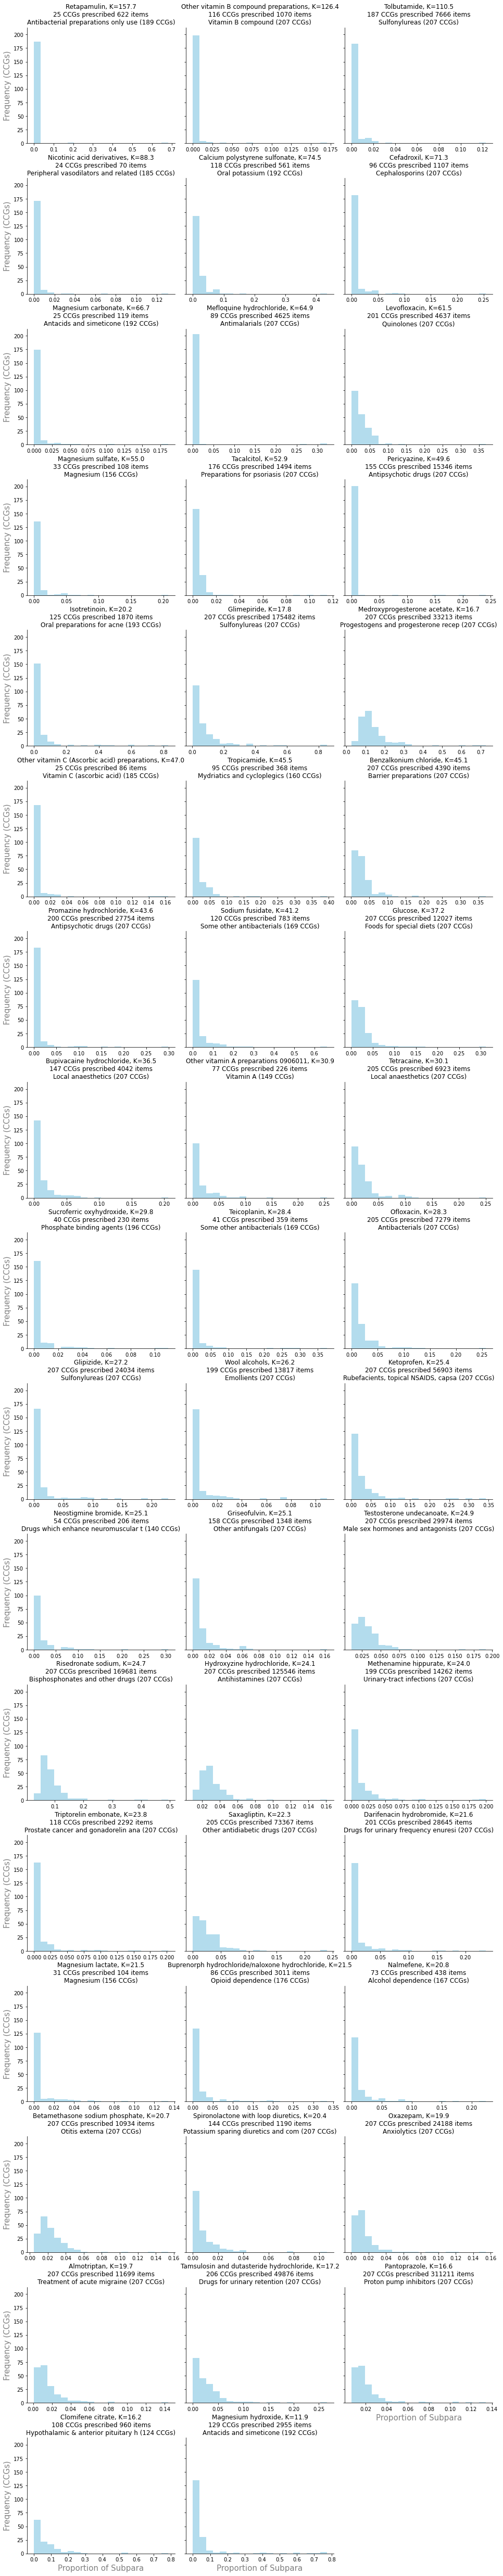

In [11]:
# plot top 50 only
## exclude practice IDs etc and select only lists of figures to plot:
dfh = rc[["chemical","chemical name","subpara name","count","count2","score","kurtosis","num_total"]].head(50).merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","count","count2","num_total"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+", K="+titles["kurtosis"].round(1).map(str)+"\n"+titles["count2"].map(int).map(str)+" CCGs prescribed "+titles["num_total"].map(int).map(str)+" items\n"+titles["subpara name"].str[0:35]+" ("+titles["count"].map(int).map(str)+" CCGs)"

titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,height=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Ranking chemicals by percentile differences / IQR etc.
First Calculate various percentiles

In [12]:
dftest = df5.transpose()
q = [0.03,0.05,0.25,0.5,0.75,0.95,0.97]

# calculate modal value for each chemical
# note where there are multiple modal values, all are given so we take max here
mo = pd.DataFrame(dftest.mode(numeric_only=True).max()).reset_index()
mo = mo.rename(columns={0:"mode"})

smy0 = dftest.describe(percentiles=q).drop(["count","mean","std"]).transpose().reset_index()

#calculate IQR
smy0["IQR"] = smy0["75%"]-smy0["25%"] 
smy0 = smy0.merge(mo, on="chemical", how="left")

smy0.head()


,chemical,min,3%,5%,25%,50%,75%,95%,97%,max,IQR,mode
0,0101010C0,0.000000,0.000000,0.00000,0.000000,0.013179,0.058570,0.193023,0.219687,0.340426,0.058570,0.0
1,0101010F0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.019306,0.033701,0.185629,0.000000,0.0
2,0101010G0,0.081081,0.149077,0.16075,0.333333,0.440633,0.590946,0.792278,0.820035,0.912442,0.257613,0.5
3,0101010I0,0.000000,0.000000,0.00000,0.000000,0.016001,0.042445,0.125394,0.159254,0.294872,0.042445,0.0
4,0101010J0,0.000000,0.000000,0.00000,0.008860,0.018857,0.037184,0.080607,0.109442,0.162162,0.028325,0.0


### Chemicals with largest ratio of 95-97th percentiles to 50-95th percentiles and with mode = 0
A large difference between the top-prescribing CCGs and the mid-high prescribing CCGs will indicate that there are several CCGs prescribing well above average levels.

In [14]:
print(f"--- Chemical filter stage 0 -> 1 ---")
print(f"Starting with {num_chemicals_stage0} chemicals")
print( "Filtering by decile (>2)")
print(f"{num_chemicals_lost_01} chemicals are removed from the bottom two deciles")
print(f"We are left with {num_chemicals_stage1} chemicals")
print(f"--- Chemical filter stage 2 -> 3 ---")
print(f"Starting with {num_chemicals_stage2} chemicals")
print( "Filtering by CCG numbers (>=50)")
print(f"{num_chemicals_lost_23} chemicals are removed due to low CCG numbers")
print(f"We are left with {num_chemicals_stage3} chemicals")
print(f"--- Chemical filter stage 4 -> 5 ---")
print(f"Starting with {num_chemicals_stage4} chemicals")
print( "Filtering by positive skew and range > 10%")
print(f"{num_chemicals_lost_45} chemicals are removed due to skew/range filtering")
print(f"We are left with {num_chemicals_stage5} chemicals")
print(f"--- Chemical filter stage 6 -> 7 ---")
print(f"Starting with {num_chemicals_stage6} chemicals")
print( "Filtering by modal proportion == 0")
print(f"{num_chemicals_lost_67} chemicals are removed due to modal proportion constraints")
print(f"We are left with {num_chemicals_stage7} chemicals")
print(f"--- Chemical filter stage 7 -> 8 ---")
print(f"Starting with {num_chemicals_stage7} chemicals")
print( "Merging with dfp")
print(f"{num_chemicals_lost_78} chemicals are removed after dfp merge")
print(f"We are left with {num_chemicals_stage8} chemicals")


--- Chemical filter stage 0 -> 1 ---
Starting with 1511 chemicals
Filtering by decile (>2)
116 chemicals are removed from the bottom two deciles
We are left with 1395 chemicals
--- Chemical filter stage 2 -> 3 ---
Starting with 1395 chemicals
Filtering by CCG numbers (>=50)
4 chemicals are removed due to low CCG numbers
We are left with 1391 chemicals
--- Chemical filter stage 4 -> 5 ---
Starting with 1391 chemicals
Filtering by positive skew and range > 10%
979 chemicals are removed due to skew/range filtering
We are left with 412 chemicals
--- Chemical filter stage 6 -> 7 ---
Starting with 1395 chemicals
Filtering by modal proportion == 0
672 chemicals are removed due to modal proportion constraints
We are left with 723 chemicals
--- Chemical filter stage 7 -> 8 ---
Starting with 723 chemicals
Merging with dfp
623 chemicals are removed after dfp merge
We are left with 100 chemicals


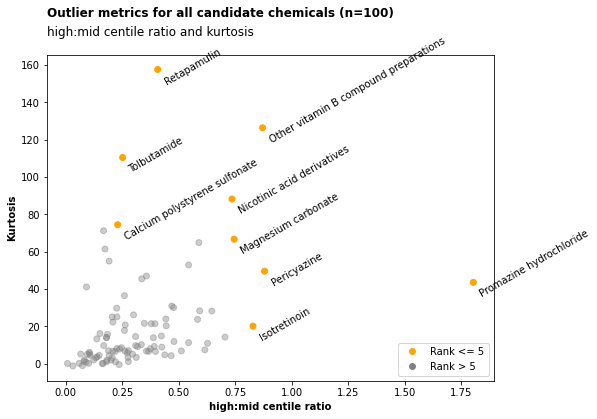

In [15]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D  # for legend handle

smy2["r_rank"]  = smy2["ratio2"].rank(ascending=False, method="min")
smy2["k_rank"]  = smy2["kurtosis"].rank(ascending=False, method="min")
num_chemicals_plotted = smy2['chemical'].nunique()

n_to_label = 5

data_to_plot = smy2[['ratio2','kurtosis','chemical name','r_rank','k_rank']].rename(columns={"chemical name":"label", "ratio2":"ratio"})
data_to_plot.set_index('label', inplace=True)


## Which chemicals to highlight?
data_to_plot['group'] = f"Rank > {n_to_label}"
data_to_plot.loc[(data_to_plot.r_rank<=n_to_label)|(data_to_plot.k_rank<=n_to_label), 'group'] = 'Rank <= 5'
colour_map = {f"Rank <= {n_to_label}":'orange', f"Rank > {n_to_label}":'grey'}
alpha_map = {f"Rank <= {n_to_label}":1, f"Rank > {n_to_label}":0.4}

fig, ax = plt.subplots()

ax.scatter(data_to_plot['ratio'], data_to_plot['kurtosis'], c=data_to_plot['group'].map(colour_map), alpha=data_to_plot['group'].map(alpha_map) )

for k, v in data_to_plot.iterrows():
    if v.group == f"Rank <= {n_to_label}":
        ax.annotate(k, (v['ratio'], v['kurtosis']), textcoords="offset points", xytext=(5,-15), ha='left', rotation=30)

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colour_map.items()]
ax.legend(title='', handles=handles, loc='lower right')
plt.xlabel("high:mid centile ratio", weight="bold")
plt.ylabel("Kurtosis", weight="bold")
plt.suptitle(f"Outlier metrics for all candidate chemicals (n={num_chemicals_plotted})", weight="bold", x=0.125, y=0.99, horizontalalignment="left")
plt.title(f"high:mid centile ratio and kurtosis", x=0, y=1.04, horizontalalignment='left' )
plt.gcf().set_size_inches(8, 6)

plt.savefig('ratio_kurtosis_plot.png', dpi=300, bbox_inches='tight')

plt.show()





In [13]:
smy2 = smy0.copy()
smy2["95-97"] = smy2["97%"]-smy2["95%"]
smy2["50-95"] = smy2["95%"]-smy2["50%"]
smy2["ratio2"] = smy2["95-97"]/smy2["50-95"]

num_chemicals_stage6 = smy2['chemical'].nunique()

# limit to those where mode is zero
smy2 = smy2.loc[smy2["mode"]==0]

num_chemicals_stage7 = smy2['chemical'].nunique()
num_chemicals_lost_67 = num_chemicals_stage6 - num_chemicals_stage7


smy2 = smy2.reset_index()
smy2 = smy2[["chemical","ratio2","25%"]].merge(dfp, on="chemical")
smy2["M2"]  = smy2["ratio2"].rank(ascending=False, method="min")

smy2.sort_values(by="ratio2",ascending=False).head(10)



num_chemicals_stage8 = smy2['chemical'].nunique()
num_chemicals_lost_78 = num_chemicals_stage7 - num_chemicals_stage8


### Histograms for top chemicals by percentile ratio (95-97th:50-95th) and with mode = 0

/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


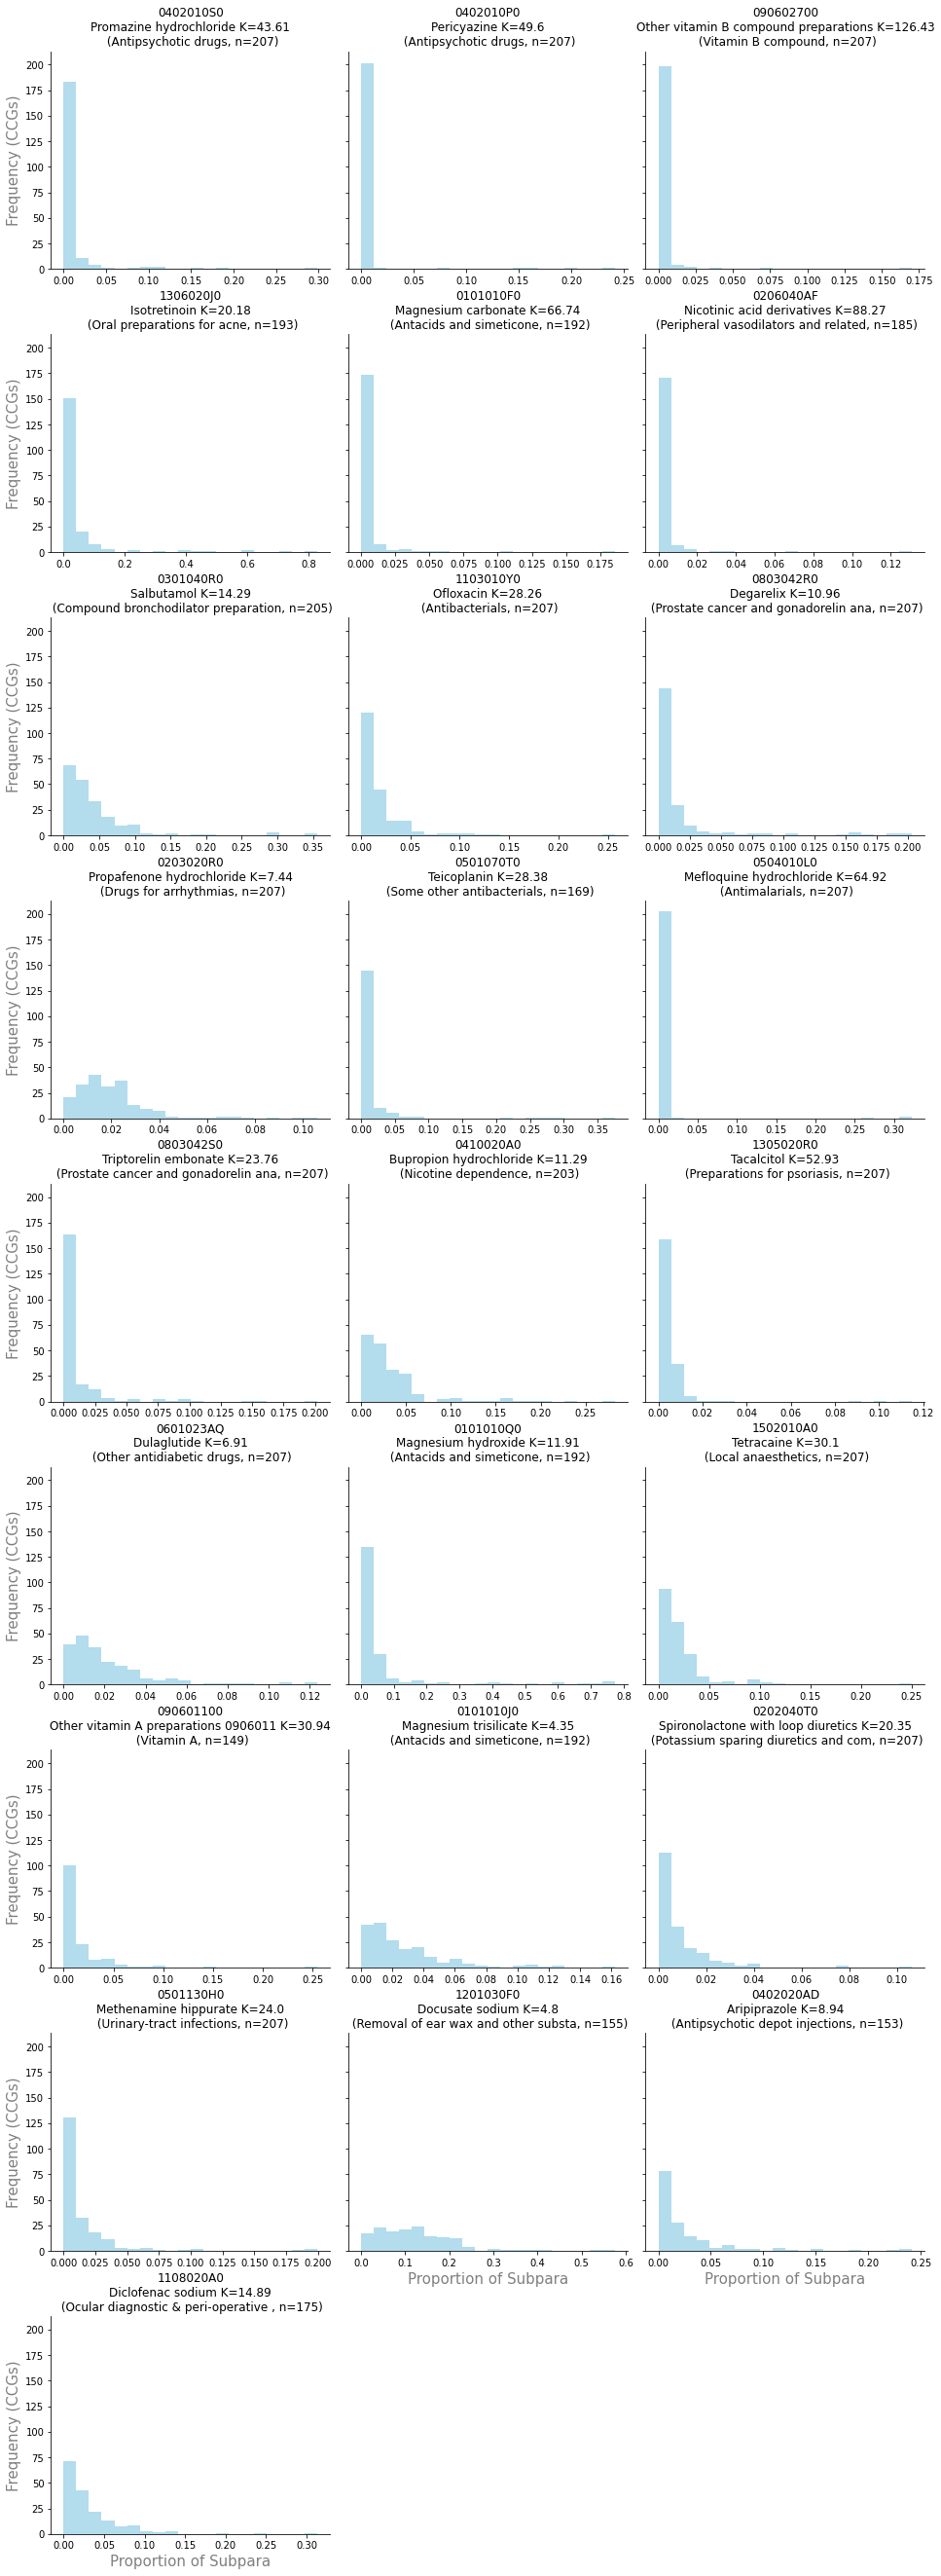

In [17]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy2.sort_values(by="ratio2",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","ratio2"]].merge(data3[["chemical","ratio"]], on="chemical")#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical","chemical name","subpara name","kurtosis","ratio2"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical"]+"\n"+ titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,height=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()